# Transfer Learning.

This is the transfer learning approach of detecting Pneumonia using Chest X-Ray Images. In the transfer learning approach, pre-built CNN like VGG16 will be used instead of re-training a new CNN. The purpose of this approach is to 1) compare how a pre-built CNN will perform compare to my previous built CNN 2) Just want to practice transfer learning.

---

The early sections of this notebook will be very similar to my previous notebook, becase I am using the same code for importing and cleaning the dataset. 

## Import Libraries

In [0]:
# suppress duplicate keras warning messages
def warn(*args, **kwargs):
    pass


import warnings
warnings.warn = warn

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D
from keras.layers import MaxPooling2D, Activation, BatchNormalization
from keras.layers import SeparableConv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0902 05:29:41.043393 140016492009344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0902 05:29:41.044610 140016492009344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0902 05:29:41.045733 140016492009344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0902 05:29:42.268652 140016492009344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

## Data Input

In [0]:
# Install PyDrive for downloading the dataset from google drive
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 8.7MB/s 


### Get Authentication for Google Drive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Download the dataset

In [0]:
file_id = '1X340OA2peo_48i71amfRTvsB9Y8Wjt2A' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ChestXRay2017.zip')

W0902 05:30:10.728477 140016492009344 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

### Unzip the dataset

In [0]:
import zipfile, os
zip_ref = zipfile.ZipFile('ChestXRay2017.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()

### Read the dataset
Below section will read each image and assign a path. These image paths will then input into a dataframe. A class label will assign to each image based on their path name as well. Two dataframe will be created below - train dataframe and test dataframe. However, these two dataframe here will not be used for the CNN because Keras takes more time to fit the model with data flow from a dataframe. These two dataframe here only used for EDA purposes. 

In [0]:
from glob import glob
from pathlib import Path

#Please change directories if you use it on your local machine.
# Training Dataset
train_dir = '/content/MODEL/chest_xray/train'  
train_normal_image_dir = Path('/content/MODEL/chest_xray/train/NORMAL')
train_pneumonia_image_dir = Path('/content/MODEL/chest_xray/train/PNEUMONIA')

# Read images based on their class.
train_normal = train_normal_image_dir.glob('*.jpeg')
train_pneumonia = train_pneumonia_image_dir.glob('*.jpeg')

# Testing Dataset
test_dir = '/content/MODEL/chest_xray/test'
test_normal_image_dir = Path('/content/MODEL/chest_xray/test/NORMAL')
test_pneumonia_image_dir = Path('/content/MODEL/chest_xray/test/PNEUMONIA')

# Read images based on their class.
test_normal = test_normal_image_dir.glob('*.jpeg')
test_pneumonia = test_pneumonia_image_dir.glob('*.jpeg')

In [0]:
# Train image list with two classes.
train_image = []

for img in train_normal:
    train_image.append((img,'Normal'))
    
for img in train_pneumonia:
    train_image.append((img,'Pneumonia'))

In [0]:
# Test image list with two classes.
test_image = []

for img in test_normal:
    test_image.append((img,'Normal'))
    
for img in test_pneumonia:
    test_image.append((img,'Pneumonia'))

In [0]:
# Create train and test dataframe
train_df = pd.DataFrame(train_image, columns=['image','label'],index=None)

test_df = pd.DataFrame(test_image, columns=['image','label'],index=None)

### Check original loaded image

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing import image

normal_sample = load_img(train_df['image'][5])
pneumonia_sample = load_img(train_df['image'][3000])

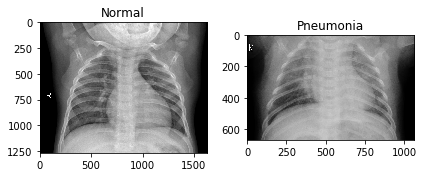

In [0]:
plt.subplot(1, 2, 1)
plt.imshow(normal_sample)
plt.title('Normal')

plt.subplot(1, 2, 2)
plt.imshow(pneumonia_sample)
plt.title('Pneumonia')

plt.tight_layout()
plt.show()

## Data Augmentation and Pre-processing

In [0]:
# Define data generator parameter and data augmentation happened here
train_datagen=ImageDataGenerator(horizontal_flip = True,
                                 rotation_range = 0.1,
                                 width_shift_range = 0.1,
                                 zoom_range = 0.1)

# Create regular training data
# Also shuffle the training dataset here so we don't have all Normal class
# at the beginning and then Pneumonia class
train_data = train_datagen.flow_from_directory(train_dir,
                                               classes = ['NORMAL','PNEUMONIA'],
                                               class_mode="categorical",
                                               target_size=(256,256),
#                                               color_mode = 'rgb',
                                               shuffle=True,
                                               seed=4)

Found 5232 images belonging to 2 classes.


In [0]:
#Create testing data
test_datagen=ImageDataGenerator()
test_data = test_datagen.flow_from_directory(test_dir,
                                             classes = ['NORMAL','PNEUMONIA'],
                                             class_mode="categorical",
                                             target_size=(256,256),
                                             shuffle=False)

Found 624 images belonging to 2 classes.


### Set model checkpoint. 

In [0]:
# Set bacth size
batch_size = 64
# Define steps per epoch
steps_per_epoch = np.ceil(len(train_df) / batch_size)

# Define checkpoint, learning rate reduce criterias
# Monitor validation loss here because I don't want my model to overfit too much
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint, EarlyStopping

lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              epsilon=0.001,
                              patience=1,
                              verbose=1)

filepath="checkpoint.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

### Transfer Learning - VGG16

In [0]:
from keras.applications import VGG16

model_VGG16 = VGG16(weights = "imagenet",include_top=False,
                    input_shape = (256,256,3))

x_VGG16 = model_VGG16.output
x_VGG16 = Flatten()(x_VGG16)
x_VGG16 = Dense(1024, activation="relu")(x_VGG16)
x_VGG16 = Dropout(0.5)(x_VGG16)
x_VGG16 = Dense(1024, activation="relu")(x_VGG16)
pred_VGG16 = Dense(2, activation="softmax")(x_VGG16)

modelVGG16_final = Model(input=model_VGG16.input, output=pred_VGG16)

modelVGG16_final.compile(loss = "categorical_crossentropy",
                         optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9),
                         metrics=["accuracy"])

modelVGG16_final.summary()

W0902 05:30:36.661247 140016492009344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 05:30:36.704379 140016492009344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 2s 0us/step


W0902 05:30:42.707335 140016492009344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0902 05:30:42.753804 140016492009344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [0]:
history_VGG16 = modelVGG16_final.fit_generator(epochs=50,
                              validation_data=test_data,
                              generator=train_data,
                              validation_steps=steps_per_epoch,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[checkpoint],
                              shuffle=False,
                              verbose=2)

W0902 05:30:42.860270 140016492009344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
 - 99s - loss: 0.5067 - acc: 0.8651 - val_loss: 0.4055 - val_acc: 0.8227

Epoch 00001: val_loss improved from inf to 0.40555, saving model to checkpoint.hdf5
Epoch 2/50
 - 87s - loss: 0.1833 - acc: 0.9314 - val_loss: 0.4558 - val_acc: 0.8508

Epoch 00002: val_loss did not improve from 0.40555
Epoch 3/50
 - 85s - loss: 0.1066 - acc: 0.9600 - val_loss: 0.4148 - val_acc: 0.8684

Epoch 00003: val_loss did not improve from 0.40555
Epoch 4/50
 - 86s - loss: 0.1281 - acc: 0.9520 - val_loss: 0.6885 - val_acc: 0.8004

Epoch 00004: val_loss did not improve from 0.40555
Epoch 5/50
 - 86s - loss: 0.1007 - acc: 0.9566 - val_loss: 0.5040 - val_acc: 0.8723

Epoch 00005: val_loss did not improve from 0.40555
Epoch 6/50
 - 86s - loss: 0.1104 - acc: 0.9581 - val_loss: 0.5328 - val_acc: 0.8516

Epoch 00006: val_loss did not improve from 0.40555
Epoch 7/50
 - 86s - loss: 0.0968 - acc: 0.9646 - val_loss: 0.3397 - val_acc: 0.8793

Epoch 00007: val_loss improved from 0.40555 to 0.33968, saving mod

### Transfer Learning - InceptionV3

In [0]:
from keras.applications import InceptionV3

model_V3 = InceptionV3(weights="imagenet",include_top=False,
                       input_shape=(256,256,3))

x_V3 = model_V3.output
x_V3 = Flatten()(x_V3)
x_V3 = Dense(1024, activation="relu")(x_V3)
x_V3 = Dropout(0.5)(x_V3)
x_V3 = Dense(1024, activation="relu")(x_V3)
pred_V3 = Dense(2, activation="softmax")(x_V3)

modelV3_final = Model(input=model_V3.input, output=pred_V3)

modelV3_final.compile(loss="categorical_crossentropy",
                      optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9),
                       metrics=["accuracy"])

modelV3_final.summary()

W0902 06:41:56.388707 140016492009344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0902 06:41:57.540595 140016492009344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4271: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



87916544/87910968 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
___________________________

In [0]:
history_V3 = modelV3_final.fit_generator(epochs=50,
                              validation_data=test_data,
                              generator=train_data,
                              validation_steps=steps_per_epoch,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[checkpoint],
                              shuffle=False,
                              verbose=2)

Epoch 1/50
 - 98s - loss: 0.3888 - acc: 0.8190 - val_loss: 0.5201 - val_acc: 0.7316

Epoch 00001: val_loss did not improve from 0.25839
Epoch 2/50
 - 81s - loss: 0.2070 - acc: 0.9150 - val_loss: 0.6132 - val_acc: 0.7438

Epoch 00002: val_loss did not improve from 0.25839
Epoch 3/50
 - 80s - loss: 0.1674 - acc: 0.9329 - val_loss: 0.4231 - val_acc: 0.8191

Epoch 00003: val_loss did not improve from 0.25839
Epoch 4/50
 - 80s - loss: 0.1446 - acc: 0.9406 - val_loss: 0.3436 - val_acc: 0.8598

Epoch 00004: val_loss did not improve from 0.25839
Epoch 5/50
 - 80s - loss: 0.1381 - acc: 0.9493 - val_loss: 0.3680 - val_acc: 0.8578

Epoch 00005: val_loss did not improve from 0.25839
Epoch 6/50
 - 79s - loss: 0.1033 - acc: 0.9627 - val_loss: 0.4233 - val_acc: 0.8465

Epoch 00006: val_loss did not improve from 0.25839
Epoch 7/50
 - 79s - loss: 0.1000 - acc: 0.9600 - val_loss: 0.3491 - val_acc: 0.8715

Epoch 00007: val_loss did not improve from 0.25839
Epoch 8/50
 - 80s - loss: 0.1088 - acc: 0.9577 -

## Evaluate the Model
The model will be evaluated in multiple ways, including accuracy/validation accuracy, precision/recall score, confusion matrix, and ROC curve. 

### Accuracy/Loss Curve

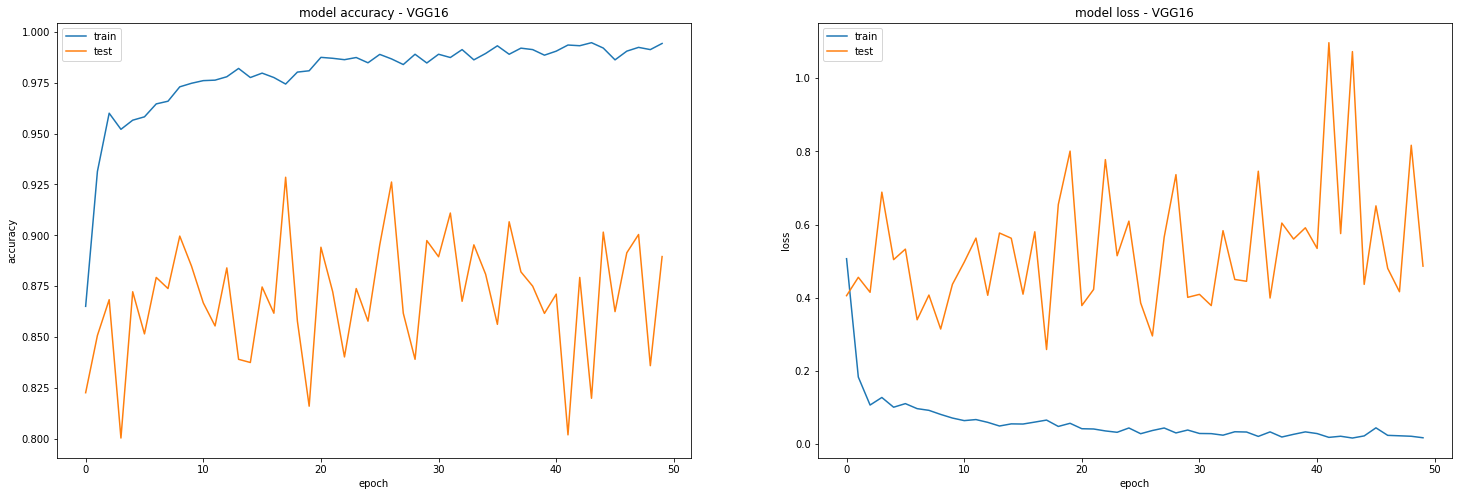

In [0]:
# Original Dataset with class weight
plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
plt.plot(history_VGG16.history['acc'])
plt.plot(history_VGG16.history['val_acc'])
plt.title('model accuracy - VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.title('model loss - VGG16')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

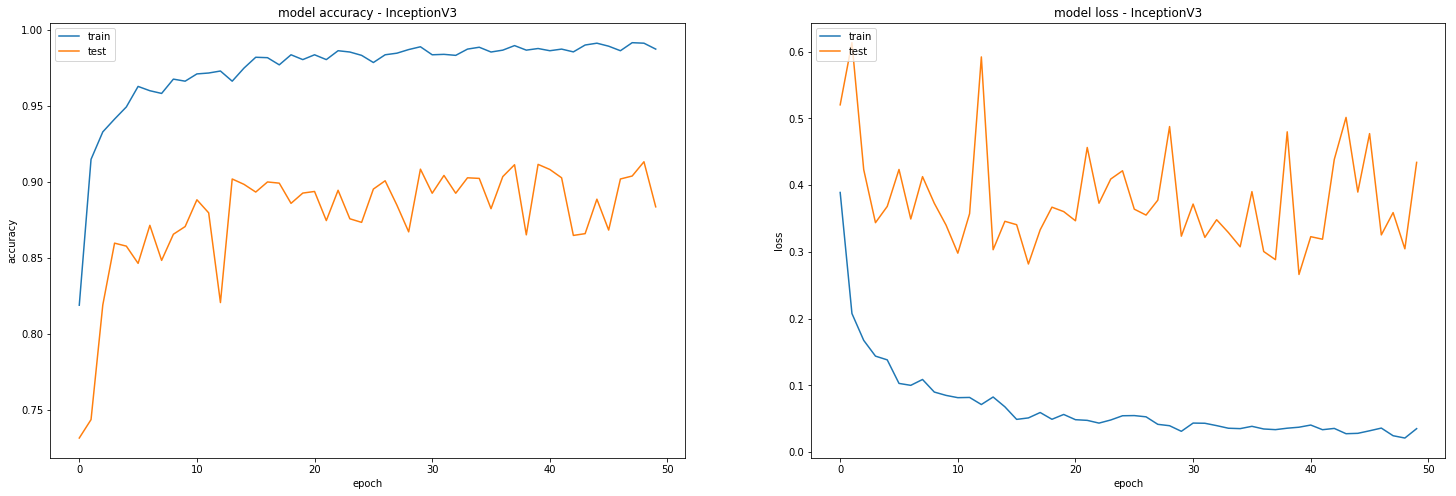

In [0]:
# Original Dataset with class weight
plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
plt.plot(history_V3.history['acc'])
plt.plot(history_V3.history['val_acc'])
plt.title('model accuracy - InceptionV3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_V3.history['loss'])
plt.plot(history_V3.history['val_loss'])
plt.title('model loss - InceptionV3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()